In [1]:
import matplotlib.pyplot as plt
from matplotlib.backend_bases import RendererBase
from scipy import signal
from scipy.io import wavfile
#import soundfile as sf
import os
import glob
import numpy as np
from PIL import Image
from scipy.fftpack import fft
from scipy.misc import imresize
from IPython.core.display import HTML
import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf
import operator
import seaborn as sns
import cv2
import random
import tensorflow_hub as hub
from tensorflow.python.data import Dataset
%matplotlib inline
# tf.logging.set_verbosity(tf.logging.INFO)
tf.logging.set_verbosity(tf.logging.ERROR)

In [2]:
audio_path = './input/train/audio/'
pict_Path = './input/picts/newtrain/'
test_pict_path = './input/picts/newtest/'
test_audio_path = './input/test/audio/'
samples = []

# os.system('rm -rf ./input/picts/test')
# os.system('rm -rf ./input/picts/train')
# os.mkdir('./input/picts/test')
# os.mkdir('./input/picts/train')

In [3]:
subFolderList = []
for x in os.listdir(audio_path):
    if os.path.isdir(audio_path + '/' + x):
        subFolderList.append(x)

In [4]:
if not os.path.exists(pict_Path):
    os.makedirs(pict_Path)

if not os.path.exists(test_pict_path):
    os.makedirs(test_pict_path)


labels_to_keep = ['yes', 'no', 'up', 'down', 'left',
                  'right', 'on', 'off', 'stop', 'go', 'silence', 'unknown']

# for f in labels_to_keep:
#     os.mkdir(pict_Path + f)
    
# for f in labels_to_keep:
#     os.mkdir(test_pict_Path + f)

In [5]:
sample_audio = []
total = 0
for x in subFolderList:
    
    # get all the wave files
    all_files = [y for y in os.listdir(audio_path + x) if '.wav' in y]
    total += len(all_files)
    # collect the first file from each dir
    sample_audio.append(audio_path  + x + '/'+ all_files[0])
    
    # show file counts
    print('count: %d : %s' % (len(all_files), x ))
print(total)

count: 1733 : tree
count: 2357 : five
count: 1746 : dog
count: 1742 : happy
count: 2372 : go
count: 2367 : right
count: 395 : _background_noise_
count: 1746 : marvin
count: 2375 : no
count: 2352 : eight
count: 2370 : one
count: 1713 : bed
count: 1731 : bird
count: 2364 : nine
count: 1745 : wow
count: 2373 : two
count: 2367 : on
count: 2380 : stop
count: 1750 : house
count: 2353 : left
count: 2377 : seven
count: 2356 : three
count: 1734 : sheila
count: 2376 : zero
count: 1733 : cat
count: 2372 : four
count: 2357 : off
count: 2377 : yes
count: 2359 : down
count: 2375 : up
count: 2369 : six
65116


In [6]:
def log_specgram(audio, sample_rate, window_size=20,
                 step_size=10, eps=1e-10):
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate / 1e3))
    freqs, _, spec = signal.spectrogram(audio,
                                    fs=sample_rate,
                                    window='hann',
                                    nperseg=nperseg,
                                    noverlap=noverlap,
                                    detrend=False)
    return freqs, np.log(spec.T.astype(np.float32) + eps)

In [7]:
def wav2img(wav_path, targetdir='', figsize=(4,4)):
    samplerate, test_sound  = wavfile.read(wav_path)
    _, spectrogram = log_specgram(test_sound, samplerate)
    spectrogram = imresize(spectrogram, (28,28))
    
    output_file = wav_path.split('/')[-1].split('.wav')[0]
    output_file = targetdir +'/'+ output_file
    #plt.imshow(spectrogram.T, aspect='auto', origin='lower')
    plt.imsave('%s.jpg' % output_file, spectrogram)
    plt.close()
    return spectrogram

In [8]:
# def wav2img(wav_path, targetdir='', figsize=(4,4)):
#     """
#     takes in wave file path
#     and the fig size. Default 4,4 will make images 288 x 288
#     """
# #     fig = plt.figure(figsize=figsize)
#     # use soundfile library to read in the wave files
#     samplerate, test_sound  = wavfile.read(wav_path)
#     _, spectrogram = log_specgram(test_sound, samplerate)
    
# #     space = spectrogram.shape[0]
# #     if space < 161:
# #         spectrogram = np.pad(spectrogram, ((161-space,0), (0,0)), mode='constant', constant_values=0)
#     spectrogram = imresize(spectrogram, (96,96))
# #     spectrogram = tf.reshape(spectrogram, [-1, 161, 161, 1])
# #     spectrogram = tf.image.resize_images(spectrogram, (96, 96))
# #     spectrogram = tf.image.grayscale_to_rgb(spectrogram)
    
#     ## create output path
#     output_file = wav_path.split('/')[-1].split('.wav')[0]
#     output_file = targetdir +'/'+ output_file
#     #plt.imshow(spectrogram.T, aspect='auto', origin='lower')
#     plt.imsave('%s.jpg' % output_file, spectrogram)
#     plt.close()
#     return spectrogram

In [9]:
def wav2img_waveform(wav_path, targetdir='', figsize=(4,4)):
    samplerate,test_sound  = wavfile.read(sample_audio[0])
    fig = plt.figure(figsize=figsize)
    plt.plot(test_sound)
    plt.axis('off')
    output_file = wav_path.split('/')[-1].split('.wav')[0]
    output_file = targetdir +'/'+ output_file
    plt.savefig('%s.png' % output_file)
    plt.close()

In [10]:
labels_to_keep = ['yes', 'no', 'up', 'down', 'left',
                  'right', 'on', 'off', 'stop', 'go']

test_labels = ['yes', 'no', 'up', 'down', 'left',
                  'right', 'on', 'off', 'stop', 'go', 'silence']

label_dict = {'yes':0, 'no':1, 'up':2, 'down':3, 'left':4,
                  'right':5, 'on':6, 'off':7, 'stop':8, 'go':9, 'silence':10}

reverse_dict = {0:'yes', 1:'no', 2:'up', 3:'down', 4:'left',
                  5:'right', 6:'on', 7:'off', 8:'stop', 9:'go', 10:'silence'}

In [11]:
# for i, x in enumerate(['yes', 'no']):
#         all_files = [y for y in os.listdir(audio_path + x) if '.wav' in y]
#         for file in all_files[:]:
#             wav2img(audio_path + x + '/' + file, './input/yes_no/' + x)

In [12]:
# #code for turning wav files into jpg.
# for i, x in enumerate(subFolderList):
#     if x in labels_to_keep:
#         print(i, ':', x)
#         # get all the wave files
#         all_files = [y for y in os.listdir(audio_path + x) if '.wav' in y]
#         for file in all_files[:]:
#             wav2img(audio_path + x + '/' + file, pict_Path + x)
#     elif x == '_background_noise_':
#         print(i, ':', x)
#         # get all the wave files
#         all_files = [y for y in os.listdir(audio_path + x) if '.wav' in y]
#         for file in all_files[:]:
#             wav2img(audio_path + x + '/' + file, "./input/picts/newtrain/silence")
#     else:
#         print(i, ':', x)
#         all_files = [y for y in os.listdir(audio_path + x) if '.wav' in y]
#         for file in all_files[:]:
#             wav2img(audio_path + x + '/' + file, "./input/picts/newtrain/unknown")

In [13]:
# for i, x in enumerate(subFolderList):
#     if x in labels_to_keep:
#         print(i, ':', x)
#         # get all the wave files
#         all_files = [y for y in os.listdir(audio_path + x) if '.wav' in y]
#         for file in all_files[101:120]:
#             wav2img(audio_path + x + '/' + file, test_pict_Path + x)
#     else:
#         all_files = [y for y in os.listdir(audio_path + x) if '.wav' in y]
#         for file in all_files[16:20]:
#             wav2img(audio_path + x + '/' + file, "./input/picts/test/unknown")

In [14]:
# test = tf.image.decode_png("./input/picts/train/down/00b01445_nohash_1.png",3)
# sess = tf.Session()
# print(sess.run(test))

In [15]:
train_images = []
train_labels = []
for i, x in enumerate(test_labels): #choose the classes to train
    all_files = [y for y in os.listdir(pict_Path + x) if '.jpg' in y]
    if x == "unknown":
        random.shuffle(all_files)
    for file in all_files[:1995]:
        train_images.append(cv2.imread(pict_Path + x + '/' + file))
        train_labels.append(label_dict[x])

train_images = np.array(train_images, dtype="float32")
train_images /= 255
train_labels = np.array(train_labels)
print(train_images.shape)
print(type(train_labels))

(20345, 28, 28, 3)
<class 'numpy.ndarray'>


In [16]:
print(train_labels.shape)

(20345,)


In [17]:
# code to shuffe feature and label arrays.
#train_labels.reshape((1, -1))
train_labels = np.array(train_labels, dtype="int32")
randomize = np.arange(len(train_labels))
np.random.shuffle(randomize)
print(train_labels)
labels = train_labels[randomize]
features = train_images[randomize]
print(labels)

[ 0  0  0 ..., 10 10 10]
[5 7 9 ..., 4 1 6]


In [18]:
print(len(labels))

20345


In [19]:
# code to split training and validation data
x = len(labels)
x *= 0.8
x = int(x)
training_examples = features[:x]
validation_examples = features[x:]

training_targets = labels[:x]
validation_targets = labels[x:]
print(training_targets)
print(validation_targets)
print(training_targets.shape)
print(validation_targets.shape)
print(training_examples)

[5 7 9 ..., 3 0 4]
[10  7  0 ...,  4  1  6]
(16276,)
(4069,)
[[[[ 0.28235295  0.28235295  0.28235295]
   [ 0.52549022  0.52549022  0.52549022]
   [ 0.58431375  0.58431375  0.58431375]
   ..., 
   [ 0.83137256  0.83137256  0.83137256]
   [ 0.91764706  0.91764706  0.91764706]
   [ 0.99215686  0.99215686  0.99215686]]

  [[ 0.28235295  0.28235295  0.28235295]
   [ 0.52549022  0.52549022  0.52549022]
   [ 0.58431375  0.58431375  0.58431375]
   ..., 
   [ 0.84313726  0.84313726  0.84313726]
   [ 0.90980393  0.90980393  0.90980393]
   [ 0.98039216  0.98039216  0.98039216]]

  [[ 0.28235295  0.28235295  0.28235295]
   [ 0.50980395  0.50980395  0.50980395]
   [ 0.57647061  0.57647061  0.57647061]
   ..., 
   [ 0.8392157   0.8392157   0.8392157 ]
   [ 0.90588236  0.90588236  0.90588236]
   [ 0.98823529  0.98823529  0.98823529]]

  ..., 
  [[ 0.27843139  0.27843139  0.27843139]
   [ 0.51764709  0.51764709  0.51764709]
   [ 0.58823532  0.58823532  0.58823532]
   ..., 
   [ 0.84313726  0.84313726 

In [20]:
def cnn_model_fn(features, labels, mode):
  """Model function for CNN."""
  # Input Layer
  input_layer = tf.reshape(features, [-1, 28, 28, 3])

  # Convolutional Layer #1
  conv1 = tf.layers.conv2d(
      inputs=input_layer,
      filters=32,
      kernel_size=[5, 5],
      padding="same",
      activation=tf.nn.relu)

  # Pooling Layer #1
  pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2) 

  # Convolutional Layer #2 and Pooling Layer #2
  conv2 = tf.layers.conv2d(
      inputs=pool1,
      filters=64,
      kernel_size=[5, 5],
      padding="same",
      activation=tf.nn.relu)
  pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)

  # Dense Layer
  pool2_flat = tf.reshape(pool2, [-1, 7 * 7 * 64])
  dense = tf.layers.dense(inputs=pool2_flat, units=1024, activation=tf.nn.relu)
  dropout = tf.layers.dropout(
      inputs=dense, rate=0.4, training=mode == tf.estimator.ModeKeys.TRAIN)

  # Logits Layer
  logits = tf.layers.dense(inputs=dropout, units=11)

  predictions = {
      # Generate predictions (for PREDICT and EVAL mode)
      "classes": tf.argmax(input=logits, axis=1),
      # Add `softmax_tensor` to the graph. It is used for PREDICT and by the
      # `logging_hook`.
      "probabilities": tf.nn.softmax(logits, name="softmax_tensor")
  }
    
  if mode == tf.estimator.ModeKeys.PREDICT:
    return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)

  # Calculate Loss (for both TRAIN and EVAL modes)
  loss = tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=logits)

  # Configure the Training Op (for TRAIN mode)
  if mode == tf.estimator.ModeKeys.TRAIN:
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.1)
    train_op = optimizer.minimize(
        loss=loss,
        global_step=tf.train.get_global_step())
    return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)

  # Add evaluation metrics (for EVAL mode)
  eval_metric_ops = {
      "accuracy": tf.metrics.accuracy(
          labels=labels, predictions=predictions["classes"])}
  return tf.estimator.EstimatorSpec(
      mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)

In [21]:
def construct_feature_columns():
  # There are 9216 pixels in each image.
  return set([tf.feature_column.numeric_column('pixels', shape=784)])

In [22]:
def create_predict_input_fn(features, labels, batch_size):#, num_epochs=None, shuffle=True):
#     print("predict input fn")
#     print(type(features))
#     print(type(labels))
#     print(type(batch_size))
    predict_input_fn = tf.estimator.inputs.numpy_input_fn(
        x=features,
        y=labels,
        num_epochs=1,
        shuffle=False)
    return predict_input_fn

def create_training_input_fn(features, labels, batch_size):#, num_epochs=None, shuffle=True):
#     print("training input fn")
#     print(type(features))
#     print(type(labels))
#     print(type(batch_size))
    train_input_fn = tf.estimator.inputs.numpy_input_fn(
        x=features,
        y=labels,
        batch_size=batch_size,
        num_epochs=None,
        shuffle=True)
    return train_input_fn

In [23]:
def train_hub_classification_model(
    learning_rate,
    steps,
    batch_size,
    hidden_units,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets):

    periods = 10
    steps_per_period = steps / periods 
#     tensors_to_log = {"probabilities": "softmax_tensor"}
# #     logging_hook = tf.train.LoggingTensorHook(
# #         tensors=tensors_to_log, every_n_iter=10)
    
    predict_training_input_fn = create_predict_input_fn(training_examples, training_targets, batch_size)
    predict_validation_input_fn = create_predict_input_fn(validation_examples, validation_targets, batch_size)
  
    training_input_fn = create_training_input_fn(training_examples, training_targets, batch_size)
    predict_training_input_fn = create_predict_input_fn(training_examples, training_targets, batch_size)
    
    predict_validation_input_fn = create_predict_input_fn(validation_examples, validation_targets, batch_size)
    training_input_fn = create_training_input_fn(training_examples, training_targets, batch_size)
  
    feature_columns = [tf.feature_column.numeric_column('pixels', shape=784)]

    my_optimizer = tf.train.AdagradOptimizer(learning_rate=learning_rate)
    my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
###############################################################
    classifier = tf.estimator.Estimator(
    model_fn=cnn_model_fn,
    model_dir="./mode_CNN_2"
    )
##############################################################################
    # Train the model, but do so inside a loop so that we can periodically assess
    # loss metrics.
    print("Training model...")
    print("LogLoss error (on validation data):")
    training_errors = []
    validation_errors = []
    for period in range (0, periods):
        classifier.train(
            input_fn=training_input_fn,
            steps=steps_per_period,
        )
        training_predictions = list(classifier.predict(input_fn=predict_training_input_fn))
        training_probabilities = np.array([item['probabilities'] for item in training_predictions])
        training_pred_class_id = np.array([item['classes'] for item in training_predictions])
        training_pred_one_hot = tf.keras.utils.to_categorical(training_pred_class_id,11) #change class number

        validation_predictions = list(classifier.predict(input_fn=predict_validation_input_fn))
        validation_probabilities = np.array([item['probabilities'] for item in validation_predictions])    
        validation_pred_class_id = np.array([item['classes'] for item in validation_predictions])
        validation_pred_one_hot = tf.keras.utils.to_categorical(validation_pred_class_id,11) #change class number

        # Compute training and validation errors.
        training_log_loss = metrics.log_loss(training_targets, training_pred_one_hot)
        validation_log_loss = metrics.log_loss(validation_targets, validation_pred_one_hot)
        # Occasionally print the current loss.
        print("  period %02d : %0.2f" % (period, validation_log_loss))
        # Add the loss metrics from this period to our list.
        training_errors.append(training_log_loss)
        validation_errors.append(validation_log_loss)
        
    print("Model training finished.")
    # Remove event files to save disk space.
    _ = map(os.remove, glob.glob(os.path.join(classifier.model_dir, 'events.out.tfevents*')))

    # Calculate final predictions (not probabilities, as above).
    final_predictions = classifier.predict(input_fn=predict_validation_input_fn)
    final_predictions = np.array([item['classes'] for item in final_predictions])


    accuracy = metrics.accuracy_score(validation_targets, final_predictions)
    print("Final accuracy (on validation data): %0.2f" % accuracy)

    # Output a graph of loss metrics over periods.
    plt.ylabel("LogLoss")
    plt.xlabel("Periods")
    plt.title("LogLoss vs. Periods")
    plt.plot(training_errors, label="training")
    plt.plot(validation_errors, label="validation")
    plt.legend()
    plt.show()

    # Output a plot of the confusion matrix.
    cm = metrics.confusion_matrix(validation_targets, final_predictions)
    # Normalize the confusion matrix by row (i.e by the number of samples
    # in each class).
    cm_normalized = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
    ax = sns.heatmap(cm_normalized, cmap="bone_r")
    ax.set_aspect(1)
    plt.title("Confusion matrix")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.show()

    return classifier

In [24]:
#len(set(training_targets))
#validation_targets
print(validation_examples.shape)
print(len(validation_examples))

(4069, 28, 28, 3)
4069


In [25]:
print(len(set(validation_targets)))
print(len(set(training_targets)))

11
11


Training model...
LogLoss error (on validation data):
  period 00 : 30.83
  period 01 : 26.37
  period 02 : 14.68
  period 03 : 10.75
  period 04 : 10.40
  period 05 : 6.88
  period 06 : 6.58
  period 07 : 5.76
  period 08 : 5.01
  period 09 : 5.03
Model training finished.
Final accuracy (on validation data): 0.85


/home/rainbowww5/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


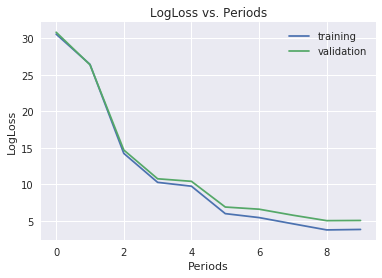

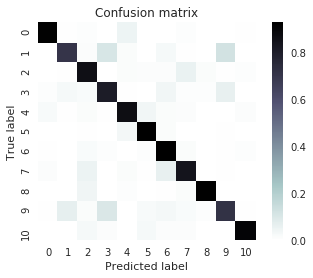

In [26]:
# training for 5000 steps, got 20% accuracy.
classifier = train_hub_classification_model(
    learning_rate=0.01,
    steps=1000,
    batch_size=100,
    hidden_units=[200, 200],
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

In [61]:
# !sudo shutdown -h now

In [27]:
classifier = tf.estimator.Estimator(
    model_fn=cnn_model_fn,
    model_dir="./mode_CNN_2",
    )

In [28]:
def my_test_input_fn(features, batch_size=1, num_epochs=None):
    raw_features = features
    ds = Dataset.from_tensor_slices((raw_features))
    ds = ds.batch(batch_size).repeat(num_epochs)
    features = ds.make_one_shot_iterator().get_next()
    return features

predict_test_input_fn = lambda: my_test_input_fn(
    test_images,
    num_epochs=1,)

In [29]:
test_images = []
fnames = []
all_files = [y for y in os.listdir(test_pict_path) if '.jpg' in y]
print(type(all_files))
i = 0
test_images = []
fnames = []
for file in all_files[:50000]:
    test_images.append(cv2.imread(test_pict_path + file))
    fnames.append(file[:-4] + '.wav')
test_images = np.array(test_images, dtype="float32")
test_images /= 255
test_predictions = classifier.predict(input_fn=predict_test_input_fn)
test_predictions = np.array([item['classes'] for item in test_predictions])

my_submission = pd.DataFrame({'fname': fnames, 'label': test_predictions})
# you could use any filename. We choose submission here
my_submission.to_csv('sub_voice_' + 'x' + '.csv', index=False)


<class 'list'>


In [30]:
# kernel keeps dying when running all test files, so I split it into thirds and concat the datasets afterward.
test_images = []
fnames = []
all_files = [y for y in os.listdir(test_pict_path) if '.jpg' in y]
print(type(all_files))
i = 0
test_images = []
fnames = []
for file in all_files[50000:100000]:
    test_images.append(cv2.imread(test_pict_path + file))
    fnames.append(file[:-4] + '.wav')
test_images = np.array(test_images, dtype="float32")
test_images /= 255
test_predictions = classifier.predict(input_fn=predict_test_input_fn)
test_predictions = np.array([item['classes'] for item in test_predictions])

my_submission = pd.DataFrame({'fname': fnames, 'label': test_predictions})
# you could use any filename. We choose submission here
my_submission.to_csv('sub_voice_' + 'y' + '.csv', index=False)


<class 'list'>


In [31]:
test_images = []
fnames = []
all_files = [y for y in os.listdir(test_pict_path) if '.jpg' in y]
print(type(all_files))
i = 0
test_images = []
fnames = []
for file in all_files[100000:]:
    test_images.append(cv2.imread(test_pict_path + file))
    fnames.append(file[:-4] + '.wav')
test_images = np.array(test_images, dtype="float32")
test_images /= 255
test_predictions = classifier.predict(input_fn=predict_test_input_fn)
test_predictions = np.array([item['classes'] for item in test_predictions])

my_submission = pd.DataFrame({'fname': fnames, 'label': test_predictions})
# you could use any filename. We choose submission here
my_submission.to_csv('sub_voice_' + 'z' + '.csv', index=False)


<class 'list'>


In [32]:
d0 = pd.read_csv("./sub_voice_" + 'x' + ".csv",sep=",")
d1 = pd.read_csv("./sub_voice_" + 'y' + ".csv",sep=",")
d2 = pd.read_csv("./sub_voice_" + 'z' + ".csv",sep=",")

df = [d0,d1,d2]
dx = pd.concat(df)

dx = dx.replace({"label": reverse_dict})

dx.to_csv('sub_CNN2.csv', index=False)
dx

,fname,label
0,clip_65e2a54b9.wav,go
1,clip_fdc9c5143.wav,go
2,clip_e485bd319.wav,up
3,clip_f4ab9fc9f.wav,go
4,clip_d89943ad6.wav,down
5,clip_bc3d11086.wav,no
6,clip_c984cdfc2.wav,on
7,clip_900e3fa16.wav,no
8,clip_db379f0d3.wav,up
9,clip_fa4530d2d.wav,go
